# Generation for NLP Baseline Code

## Install Packages

In [1]:
!pip install -r requirements.txt

## Import Necessary Libraries

In [1]:
import torch
import transformers
from ast import literal_eval
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM, SFTConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import Dataset
import json
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import evaluate
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from peft import AutoPeftModelForCausalLM, LoraConfig

pd.set_option('display.max_columns', None)

In [2]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

## EDA

### Load Data

In [3]:
# Load the train dataset
# TODO Train Data 경로 입력
dataset = pd.read_csv('../data/train.csv')

# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
df = pd.DataFrame(records)

In [4]:
df.head()

,id,paragraph,question,choices,answer,question_plus
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None
1,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None
2,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None
3,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None
4,generation-for-nlp-431,(가)의 사신 고제덕 등이 일본에 와서 왕이 보낸 국서를 전하였다. 그 국서에 이르...,(가) 국가에 대한 설명으로 옳은 것은?,"[나 당연합군의 공격으로 멸망하였다 ., 9주 5소경의 지방 행정 구역을 두었다 ....",3,None


### Print missing values

In [5]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
id                  0
paragraph           0
question            0
choices             0
answer              0
question_plus    2029
dtype: int64


### Basic information about the dataset

In [6]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2029 non-null   object
 1   paragraph      2029 non-null   object
 2   question       2029 non-null   object
 3   choices        2029 non-null   object
 4   answer         2029 non-null   int64 
 5   question_plus  0 non-null      object
dtypes: int64(1), object(5)
memory usage: 95.2+ KB


### EDA on 'question' and 'choices'

In [7]:
# Combine 'question' and 'question_plus' if available
df['question_plus'] = df['question_plus'].fillna('')
df['full_question'] = df.apply(lambda x: x['question'] + ' ' + x['question_plus'] if x['question_plus'] else x['question'], axis=1)

# Calculate the length of each question
df['question_length'] = df['full_question'].apply(len)

### Question Length Distribution

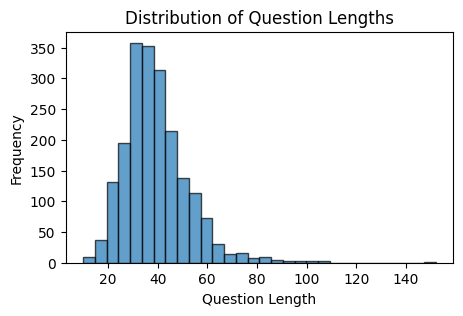

In [8]:
plt.figure(figsize=(5, 3))
plt.hist(df['question_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

## Feature Engineering using TF-IDF

- TF-IDF 참고 링크: https://ko.wikipedia.org/wiki/Tf-idf

### Initialize TF-IDF Vectorizer

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

### Fit and transform the text data

In [10]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df['full_question'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

### Display the TF-IDF features

In [11]:
print("\nTF-IDF Features:")
display(tfidf_df.head(20))


TF-IDF Features:


11월  12월  1450  1450년에서  1750  1750년  17세기  1800년대  1860년  1960년대  1999년  \
0   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
1   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
2   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
3   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
4   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
5   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
6   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
7   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
8   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
9   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
10  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
11  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
12  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
13  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
14  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
15  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
16  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
17  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
18  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
19  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   

    19세기  1분기   1월   1위  1위를   1의  2008년  2010년  2013년  2014  2014년  2014년도  \
0    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
5    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
6    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
7    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
8    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
9    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
10   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
11   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
12   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
13   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
14   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
15   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
16   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
17   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
18   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
19   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   

    2015학년도  2019  2019년  2020  2020년  20세기  2분기  2에서  3분기   5년   5월  600  \
0       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7       0.0   0.0    0.0   0.0    0.0   0.0  0.

## Model Training

### Baseline Model

- https://huggingface.co/beomi/gemma-ko-2b

In [ ]:
# 본인의 Huggingface auth token 입력
## Jupyter lab에서 로그인 하는 textbox가 나오지 않을 경우, terminal에서 로그인 하실 수 있습니다.
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): Traceback (most recent call last):
  File "/opt/conda/bin/huggingface-c

: 

모델과 토크나이저를 불러옵니다.

In [16]:
model = AutoModelForCausalLM.from_pretrained(
    "beomi/gemma-ko-2b",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(
    "beomi/gemma-ko-2b",
    trust_remote_code=True,
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

gemma-ko-2b 모델에는 chat template 이 없기 때문에 직접 입력해주어야 합니다.

In [17]:
tokenizer.chat_template = "{% if messages[0]['role'] == 'system' %}{% set system_message = messages[0]['content'] %}{% endif %}{% if system_message is defined %}{{ system_message }}{% endif %}{% for message in messages %}{% set content = message['content'] %}{% if message['role'] == 'user' %}{{ '<start_of_turn>user\n' + content + '<end_of_turn>\n<start_of_turn>model\n' }}{% elif message['role'] == 'assistant' %}{{ content + '<end_of_turn>\n' }}{% endif %}{% endfor %}"

### Prepare LoRA

In [18]:
peft_config = LoraConfig(
    r=6,
    lora_alpha=8,
    lora_dropout=0.05,
    target_modules=['q_proj', 'k_proj'],
    bias="none",
    task_type="CAUSAL_LM",
)

### Data Processing

In [19]:
dataset = Dataset.from_pandas(df)

In [20]:
PROMPT_NO_QUESTION_PLUS = """지문:
{paragraph}

질문:
{question}

선택지:
{choices}

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:"""

PROMPT_QUESTION_PLUS = """지문:
{paragraph}

질문:
{question}

<보기>:
{question_plus}

선택지:
{choices}

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:"""

In [21]:
dataset

Dataset({
    features: ['id', 'paragraph', 'question', 'choices', 'answer', 'question_plus', 'full_question', 'question_length'],
    num_rows: 2031
})

In [22]:
processed_dataset = []
for i in range(len(dataset)):
    choices_string = "\n".join([f"{idx + 1} - {choice}" for idx, choice in enumerate(dataset[i]["choices"])])

    # <보기>가 있을 때
    if dataset[i]["question_plus"]:
        user_message = PROMPT_QUESTION_PLUS.format(
            paragraph=dataset[i]["paragraph"],
            question=dataset[i]["question"],
            question_plus=dataset[i]["question_plus"],
            choices=choices_string,
        )
    # <보기>가 없을 때
    else:
        user_message = PROMPT_NO_QUESTION_PLUS.format(
            paragraph=dataset[i]["paragraph"],
            question=dataset[i]["question"],
            choices=choices_string,
        )

    # chat message 형식으로 변환
    processed_dataset.append(
        {
            "id": dataset[i]["id"],
            "messages": [
                {"role": "system", "content": "지문을 읽고 질문의 답을 구하세요."},
                {"role": "user", "content": user_message},
                {"role": "assistant", "content": f"{dataset[i]['answer']}"}
            ],
            "label": dataset[i]["answer"],
        }
    )


In [23]:
processed_dataset[0]

{'id': 'generation-for-nlp-425',
 'messages': [{'role': 'system', 'content': '지문을 읽고 질문의 답을 구하세요.'},
  {'role': 'user',
   'content': '지문:\n상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服) 절차에 대하여 논한 것이 신과는 큰 차이가 있었습니다 . 장자를 위하여 3년을 입는 까닭은 위로 ‘정체(正體)’가 되기 때문이고 또 전 중(傳重: 조상의 제사나 가문의 법통을 전함)하기 때문입니다 . …(중략) … 무엇보다 중요한 것은 할아버지와 아버지의 뒤를 이은 ‘정체’이지, 꼭 첫째이기 때문에 참 최 3년 복을 입는 것은 아닙니다 .”라고 하였다 .－현종실록 －ㄱ.기 사환국으로 정권을 장악하였다 .ㄴ.인 조반정을 주도 하여 집권세력이 되었다 .ㄷ.정조 시기에 탕평 정치의 한 축을 이루었다 .ㄹ.이 이와 성혼의 문인을 중심으로 형성되었다.\n\n질문:\n상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?\n\n선택지:\n1 - ㄱ, ㄴ\n2 - ㄱ, ㄷ\n3 - ㄴ, ㄹ\n4 - ㄷ, ㄹ\n\n1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.\n정답:'},
  {'role': 'assistant', 'content': '2'}],
 'label': 2}

In [24]:
processed_dataset = Dataset.from_pandas(pd.DataFrame(processed_dataset))
processed_dataset

Dataset({
    features: ['id', 'messages', 'label'],
    num_rows: 2031
})

In [25]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example["messages"])):
        output_texts.append(
            tokenizer.apply_chat_template(
                example["messages"][i],
                tokenize=False,
            )
        )
    return output_texts

def tokenize(element):
    outputs = tokenizer(
        formatting_prompts_func(element),
        truncation=False,
        padding=False,
        return_overflowing_tokens=False,
        return_length=False,
    )
    return {
        "input_ids": outputs["input_ids"],
        "attention_mask": outputs["attention_mask"],
    }

# 데이터 토큰화
tokenized_dataset = processed_dataset.map(
    tokenize,
    remove_columns=list(processed_dataset.features),
    batched=True,
    num_proc=4,
    load_from_cache_file=True,
    desc="Tokenizing",
)

Tokenizing (num_proc=4):   0%|          | 0/2031 [00:00<?, ? examples/s]

In [26]:
# 데이터 분리
# vram memory 제약으로 인해 인풋 데이터의 길이가 1024 초과인 데이터는 제외하였습니다. *힌트: 1024보다 길이가 더 긴 데이터를 포함하면 더 높은 점수를 달성할 수 있을 것 같습니다!
tokenized_dataset = tokenized_dataset.filter(lambda x: len(x["input_ids"]) <= 1024)  
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['test']
# 데이터 확인
print(tokenizer.decode(train_dataset[0]["input_ids"], skip_special_tokens=True))

Filter:   0%|          | 0/2031 [00:00<?, ? examples/s]

지문을 읽고 질문의 답을 구하세요.<start_of_turn>user
지문:
"이 법이 통과된 이후 누구든 흑인이나 흑인 혼혈을 평생 노예나 하인으로 부릴 목적, 혹은 어떤 용어를 사용하든 무력이나 폭력으로 판매 또는 처분하거나, 판매의 원인이 되거나, 구류 또는 억류하거나, 구류나 억류의 원인이 되게 할 목적 또는 의도로 납치하거나, 이동하거나, 납치당하게 하거나, 이동당하게 하거나, 사기나 허위로 유혹하거나, 유혹당하게 하거나, 또는 탑치하거나, 이동하거나, 유혹하려는 목적으로 여하한 흑인이나 흑인 혼혈을 이 영연방 일부에서 여하한 다른 지역이나 이 영연방 외부로 데려간다면 그러한 사람 모두는 물론 조력자나 방조자 역시 적절한 관할권이 있는 영연방 법원에서 중범죄로 유죄 판결을 받는다." —1826년 펜실베니아 법률 발췌

질문:
비평가들이 대법원에서 이 1826년 법률의 합헌성에 이의를 제기한 이유를 고르시오.

선택지:
1 - 취득자 법안에 대한 헌법적 금지명령을 위반했다.
2 - 헌법의 도망노예 조항의 의도를 훼손했다.
3 - 헌법의 3/5 조항을 우회했다.
4 - 수정헌법 제5조의 '수용권' 조항에 위배된다.

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:<end_of_turn>
<start_of_turn>model
2<end_of_turn>



In [27]:
print(tokenizer.decode(train_dataset[0]["input_ids"], skip_special_tokens=False))

<bos>지문을 읽고 질문의 답을 구하세요.<start_of_turn>user
지문:
"이 법이 통과된 이후 누구든 흑인이나 흑인 혼혈을 평생 노예나 하인으로 부릴 목적, 혹은 어떤 용어를 사용하든 무력이나 폭력으로 판매 또는 처분하거나, 판매의 원인이 되거나, 구류 또는 억류하거나, 구류나 억류의 원인이 되게 할 목적 또는 의도로 납치하거나, 이동하거나, 납치당하게 하거나, 이동당하게 하거나, 사기나 허위로 유혹하거나, 유혹당하게 하거나, 또는 탑치하거나, 이동하거나, 유혹하려는 목적으로 여하한 흑인이나 흑인 혼혈을 이 영연방 일부에서 여하한 다른 지역이나 이 영연방 외부로 데려간다면 그러한 사람 모두는 물론 조력자나 방조자 역시 적절한 관할권이 있는 영연방 법원에서 중범죄로 유죄 판결을 받는다." —1826년 펜실베니아 법률 발췌

질문:
비평가들이 대법원에서 이 1826년 법률의 합헌성에 이의를 제기한 이유를 고르시오.

선택지:
1 - 취득자 법안에 대한 헌법적 금지명령을 위반했다.
2 - 헌법의 도망노예 조항의 의도를 훼손했다.
3 - 헌법의 3/5 조항을 우회했다.
4 - 수정헌법 제5조의 '수용권' 조항에 위배된다.

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:<end_of_turn>
<start_of_turn>model
2<end_of_turn>



In [28]:
train_dataset_token_lengths = [len(train_dataset[i]["input_ids"]) for i in range(len(train_dataset))]
print(f"max token length: {max(train_dataset_token_lengths)}")
print(f"min token length: {min(train_dataset_token_lengths)}")
print(f"avg token length: {np.mean(train_dataset_token_lengths)}")

max token length: 1023
min token length: 142
avg token length: 588.688710754843


In [29]:
print(tokenizer.chat_template)

{% if messages[0]['role'] == 'system' %}{% set system_message = messages[0]['content'] %}{% endif %}{% if system_message is defined %}{{ system_message }}{% endif %}{% for message in messages %}{% set content = message['content'] %}{% if message['role'] == 'user' %}{{ '<start_of_turn>user
' + content + '<end_of_turn>
<start_of_turn>model
' }}{% elif message['role'] == 'assistant' %}{{ content + '<end_of_turn>
' }}{% endif %}{% endfor %}


Completion 부분만 학습하기 위한 data collator 설정

- 텍스트 중 response_template 까지는 ignore_index 로 loss 계산에서 제외
- 텍스트 중 response_template 이후는 학습에 포함 (정답 + eos 토큰)

In [37]:
response_template = "<start_of_turn>model"
data_collator = DataCollatorForCompletionOnlyLM(
    response_template=response_template,
    tokenizer=tokenizer,
) 

print(data_collator)

DataCollatorForCompletionOnlyLM(tokenizer=GemmaTokenizerFast(name_or_path='beomi/gemma-ko-2b', vocab_size=256000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, mlm=False, mlm_probability=0.15, pad_to_multiple_of=None, tf_experimental_compile=False, return_tensors='pt')


### Metric 설정

In [ ]:
# 모델의 logits 를 조정하여 정답 토큰 부분만 출력하도록 설정
def preprocess_logits_for_metrics(logits, labels):
    logits = logits if not isinstance(logits, tuple) else logits[0]
    logit_idx = [tokenizer.vocab["1"], tokenizer.vocab["2"], tokenizer.vocab["3"], tokenizer.vocab["4"], tokenizer.vocab["5"]]
    logits = logits[:, -2, logit_idx] # -2: answer token, -1: eos token
    return logits

# metric 로드
acc_metric = evaluate.load("accuracy")

# 정답 토큰 매핑
int_output_map = {"1": 0, "2": 1, "3": 2, "4": 3, "5": 4}

# metric 계산 함수
def compute_metrics(evaluation_result):
    logits, labels = evaluation_result 
    
    # 토큰화된 레이블 디코딩
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    labels = list(map(lambda x: x.split("<end_of_turn>")[0].strip(), labels))
    labels = list(map(lambda x: int_output_map[x], labels))

    # 소프트맥스 함수를 사용하여 로그트 변환
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)
    predictions = np.argmax(probs, axis=-1)

    # 정확도 계산
    acc = acc_metric.compute(predictions=predictions, references=labels)
    return acc

### Train

In [31]:
# pad token 설정
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.special_tokens_map

{'bos_token': '<bos>',
 'eos_token': '<eos>',
 'unk_token': '<unk>',
 'pad_token': '<eos>'}

In [ ]:
tokenizer.padding_side = 'right'

sft_config = SFTConfig(
    do_train=True,
    do_eval=True,
    lr_scheduler_type="cosine",
    max_seq_length=1024,
    output_dir="outputs_gemma",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    learning_rate=2e-6,
    weight_decay=0.01,
    logging_steps=1,
    save_strategy="epoch",
    eval_strategy="epoch",
    save_total_limit=2,
    save_only_model=True,
    report_to="none",
)

train_dataset_4 = train_dataset.shuffle(seed=42).select(range(1))
eval_dataset_4 = eval_dataset.shuffle(seed=42).select(range(1)) 

print(train_dataset_4[0])

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset_4,
    eval_dataset=eval_dataset_4,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    peft_config=peft_config,
    args=sft_config,
)

NameError: name 'tokenizer' is not defined

: 

In [35]:
%%time

trainer.train()

Epoch,Training Loss,Validation Loss


로짓:  [[3.125 2.932 1.979 1.365 1.209]]
레이블:  [[  -100   -100   -100   -100   -100   -100   -100   -100   -100   -100
    -100   -100   -100   -100   -100   -100   -100   -100   -100   -100
    -100   -100   -100   -100   -100   -100   -100   -100   -100   -100
    -100   -100   -100   -100   -100   -100   -100   -100   -100   -100
    -100   -100   -100   -100   -100   -100   -100   -100   -100   -100
    -100   -100   -100   -100   -100   -100   -100   -100   -100   -100
    -100   -100   -100   -100   -100   -100   -100   -100   -100   -100
    -100   -100   -100   -100   -100   -100   -100   -100   -100   -100
    -100   -100   -100   -100   -100   -100   -100   -100   -100   -100
    -100   -100   -100   -100   -100   -100   -100   -100   -100   -100
    -100   -100   -100   -100   -100   -100   -100   -100   -100   -100
    -100   -100   -100   -100   -100   -100   -100   -100   -100   -100
    -100   -100   -100   -100   -100   -100   -100   -100   -100   -100
    -100   -100   -

RuntimeError: "softmax_lastdim_kernel_impl" not implemented for 'Half'

## Inference

In [34]:
# TODO 학습된 Checkpoint 경로 입력
checkpoint_path = "outputs_gemma/checkpoint-4491"

model = AutoPeftModelForCausalLM.from_pretrained(
    checkpoint_path,
    trust_remote_code=True,
    # torch_dtype=torch.bfloat16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(
    checkpoint_path,
    trust_remote_code=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [35]:
# Load the test dataset
# TODO Test Data 경로 입력
test_df = pd.read_csv('test.csv')

# Flatten the JSON dataset
records = []
for _, row in test_df.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
test_df = pd.DataFrame(records)

In [36]:
test_dataset = []
for i, row in test_df.iterrows():
    choices_string = "\n".join([f"{idx + 1} - {choice}" for idx, choice in enumerate(row["choices"])])
    len_choices = len(row["choices"])
    
    # <보기>가 있을 때
    if row["question_plus"]:
        user_message = PROMPT_QUESTION_PLUS.format(
            paragraph=row["paragraph"],
            question=row["question"],
            question_plus=row["question_plus"],
            choices=choices_string,
        )
    # <보기>가 없을 때
    else:
        user_message = PROMPT_NO_QUESTION_PLUS.format(
            paragraph=row["paragraph"],
            question=row["question"],
            choices=choices_string,
        )

    test_dataset.append(
        {
            "id": row["id"],
            "messages": [
                {"role": "system", "content": "지문을 읽고 질문의 답을 구하세요."},
                {"role": "user", "content": user_message},
            ],
            "label": row["answer"],
            "len_choices": len_choices,
        }
    )

In [37]:
%%time

infer_results = []

pred_choices_map = {0: "1", 1: "2", 2: "3", 3: "4", 4: "5"}

model.eval()
with torch.inference_mode():
    for data in tqdm(test_dataset):
        _id = data["id"]
        messages = data["messages"]
        len_choices = data["len_choices"]

        outputs = model(
            tokenizer.apply_chat_template(
                messages,
                tokenize=True,
                add_generation_prompt=True,
                return_tensors="pt",
            ).to("cuda")
        )

        logits = outputs.logits[:, -1].flatten().cpu()

        target_logit_list = [logits[tokenizer.vocab[str(i + 1)]] for i in range(len_choices)]

        probs = (
            torch.nn.functional.softmax(
                torch.tensor(target_logit_list, dtype=torch.float32)
            )
            .detach()
            .cpu()
            .numpy()
        )

        predict_value = pred_choices_map[np.argmax(probs, axis=-1)]
        infer_results.append({"id": _id, "answer": predict_value})

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 869/869 [18:26<00:00,  1.27s/it]

CPU times: user 17min, sys: 1min 26s, total: 18min 27s
Wall time: 18min 26s


In [38]:
pd.DataFrame(infer_results).to_csv("output.csv", index=False)

In [62]:
pd.DataFrame(infer_results)

""
